<a href="https://colab.research.google.com/github/rliu7926/nie-research-project/blob/master/4.5%20Mass%20Distribution%20Calculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'
! pip install astropy
! pip install sympy

from astropy.cosmology import FlatLambdaCDM, Planck18, z_at_value
import astropy
import numpy as np
from numpy import diff 
import pylab
import math
import progressbar

import astropy.units as u
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numpy import trapz

from pycbc import waveform
from pycbc.waveform import get_td_waveform, get_fd_waveform

import pycbc
import pycbc.noise
import pycbc.psd

from random import randint
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pandas as pd
from pycbc.types import TimeSeries

import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import time

     |████████████████████████████████| 3.1 MB 5.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 28.5 MB 55 kB/s 
     |████████████████████████████████| 75 kB 3.0 MB/s 
     |████████████████████████████████| 1.6 MB 31.7 MB/s 
     |████████████████████████████████| 52 kB 856 kB/s 
     |████████████████████████████████| 1.0 MB 30.4 MB/s 
     |████████████████████████████████| 54 kB 1.9 MB/s 
     |████████████████████████████████| 3.2 MB 31.8 MB/s 


In [ ]:
## Create frequency series waveform function (for expectation value function)

def create_fd_waveform(mass1, mass2, spin1, spin2, fres, flow, dist, cosmology=Planck18, approximant="IMRPhenomPv2"):

  redshift = 1 + z_at_value(cosmology.comoving_distance, dist * u.Mpc)
  lum_dist = cosmology.luminosity_distance(redshift-1)
  flow_bound = flow * redshift

  hplus, hcross = get_fd_waveform(approximant=approximant,
                                  mass1=mass1, mass2=mass2,
                                  spin1x=spin1[0], spin1y=spin1[1], spin1z=spin1[2],
                                  spin2x=spin2[0], spin2y=spin2[1], spin2z=spin2[2],
                                  delta_f=fres * redshift,
                                  f_lower=flow_bound)
  
  freq_value = hplus.sample_frequencies / redshift
  freq_amp = hplus / lum_dist * redshift

  return freq_amp, freq_value


In [ ]:
## Expectation value function (taken from 4.1)

def expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, dist, tdist, psd, cosmology=Planck18, approximant="IMRPhenomD", output="Yes"):

  ## Create waveform and template

  gw_amp, gw_value = create_fd_waveform(mass1=mass1, mass2=mass2, spin1=spin1, spin2=spin2, fres=fres, flow=flow, dist=dist, approximant=approximant)
  signal_amp, signal_value = create_fd_waveform(mass1=tmass1, mass2=tmass2, spin1=tspin1, spin2=tspin2, fres=fres, flow=flow, dist=tdist, approximant=approximant)

  gwfreq = pycbc.types.frequencyseries.FrequencySeries(initial_array=gw_amp, delta_f=fres)
  signalfreq = pycbc.types.frequencyseries.FrequencySeries(initial_array=signal_amp, delta_f=fres)

  ## Create PSD 

  flen = len(gw_value)

  if psd == 'aLIGOAPlusDesignSensitivityT1800042':
    psdfreq = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, fres, flow)
  
  if psd == 'aLIGODesignSensitivityP1200087':
    psdfreq = pycbc.psd.aLIGODesignSensitivityP1200087(flen, fres, flow)

  if psd == 'CosmicExplorerP1600143':
    psdfreq = pycbc.psd.CosmicExplorerP1600143(flen, fres, flow)
    

  ## Calculate SNR

  gwdata = gwfreq + psdfreq
  snr = matched_filter(template=signalfreq, data=gwdata, psd=psdfreq, low_frequency_cutoff=flow)

  if output == 'Yes':
    print("The signal-to-noise ratio is: {}".format(max(abs(snr))))
  
  return(max(abs(snr)))
  

In [ ]:
## Distance estimation function, updated with new parameters

def estimate_distance(snr, guess, alpha, iterations, tolerance, mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, dist='param', psd='aLIGODesignSensitivityP1200087', cosmology=Planck18, approximant='IMRPhenomD', output='Yes'): 
  
  if dist == 'param':
    pred = guess
    estimate = expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, guess, guess, psd, cosmology, approximant)
    print("Initial guess: {}".format(estimate))

    diff = 1
    iter = 0

    while iter < iterations and abs(diff) > tolerance:
      diff = snr - estimate
      pred = pred + alpha * diff
      estimate = expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, pred, pred, psd, cosmology, approximant)
      iter = iter + 1
      print("Iteration {}: Estimate {}, Distance {}".format(iter, estimate, pred))
    
  else: 
    print("Nothing to estimate: distance needs to be set to param")

  print("Final estimate: {}, off by {}".format(pred, diff))
  return(pred, diff) 

In [ ]:
## Mass distribution model: POWER LAW + PEAK 

def powerlaw(x, alpha, min, max):
  if x < min:
    return 0
  if x > max: 
    return 0
  else:
    return (alpha - 1)/min * (x/min)**(-alpha) / (1 - (max/min)**(1-alpha))

def gaussian(x, mean, sd): 
  return 1/(np.sqrt(2*np.pi)*sd) * math.exp(-(x-mean)**2/(2*sd))

def smoothing(x, min, delta):
  if x <= min: 
    return 0
  if x >= (min + delta): 
    return 1
  else:
    if (delta/(x-min) + delta/(x-min-delta)) < 100:
      return (math.exp(delta/(x-min) + delta/(x-min-delta)) + 1)**-1
    else:
      return 0

def plp(x, peak, alpha, min, max, delta, mu, sigma):
  if min <= x <= max:
    return smoothing(x=x, min=min, delta=delta) * ((1-peak)*powerlaw(x=x, alpha=alpha, min=min, max=max) + peak*gaussian(x=x, mean=mu, sd=sigma))
  else:
    return 0

## Mass ratio model

def plpq(q, m1, beta, min, delta):
  if q*m1 <= min: 
    return 0
  else: 
    return q**beta * smoothing(x=q*m1, min=min, delta=delta)

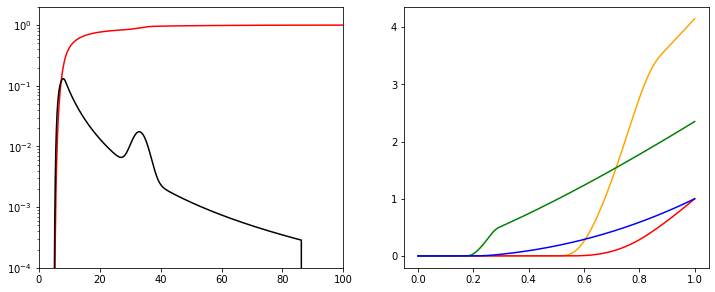

In [ ]:
masses = np.arange(0, 100, 0.01)
qlist = np.arange(0, 1, 0.0001)

plpdist, plpdist_int = ([0] * len(masses) for i in range(2))
plpq10, plpq10_int, plpq30, plpq30_int = ([0] * len(qlist) for i in range(4))

for i in range(len(masses)):
  plpdist[i] = plp(x=masses[i], peak=0.10, alpha=2.63, delta=4.82, min=4.59, max=86.22, mu=33.07, sigma=5.69)

for i in range(len(masses)):
  plpdist_int[i] = trapz(y=np.array(plpdist)[0:i,], x=np.array(masses[0:i,]))

for i in range(len(qlist)):
  plpq10[i] = plpq(q=qlist[i], m1=10, beta=1.26, min=4.59, delta=4.82)
  plpq30[i] = plpq(q=qlist[i], m1=30, beta=1.26, min=4.59, delta=4.82)

for i in range(len(qlist)):
  plpq10_int[i] = trapz(y=np.array(plpq10)[0:i,], x=np.array(qlist)[0:i,])
  plpq30_int[i] = trapz(y=np.array(plpq30)[0:i,], x=np.array(qlist)[0:i,])

fig = plt.figure(figsize=(12, 4.8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(masses, plpdist_int/max(plpdist_int), color="red")
ax1.plot(masses, plpdist/max(plpdist_int), color="black")
ax1.set_yscale('log')
ax1.set_ylim(0.0001, 2)
ax1.set_xlim(0, 100)

ax2.plot(qlist, plpq10/max(plpq10_int), color="orange")
ax2.plot(qlist, plpq10_int/max(plpq10_int), color="red")
ax2.plot(qlist, plpq30/max(plpq30_int), color="green")
ax2.plot(qlist, plpq30_int/max(plpq30_int), color="blue")

In [ ]:
## Mass distribution model: BROKEN POWER LAW 

def bpl(x, alpha1, alpha2, min, max, b, delta):
  cutoff = min + b*(max - min)
  if min < x < cutoff:
    return x**-alpha1 * smoothing(x=x, min=min, delta=delta)
  if cutoff < x < max: 
    return x**-alpha2 * smoothing(x=x, min=min, delta=delta) * (cutoff**-alpha1/cutoff**-alpha2)
  else: 
    return 0

## Mass ratio model 

def bplq(q, m1, beta, min): 
  if q*m1 > min: 
    return q**beta
  else: 
    return 0


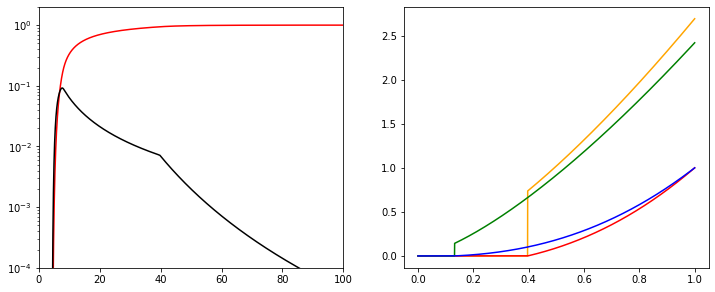

In [ ]:
masses = np.arange(0, 100, 0.01)
qlist = np.arange(0, 1, 0.0001)

bpldist, bpldist_int = ([0] * len(masses) for i in range(2))
bplq10, bplq10_int, bplq30, bplq30_int = ([0] * len(qlist) for i in range(4))

for i in range(len(masses)):
  bpldist[i] = bpl(x=masses[i], alpha1=1.58, alpha2=5.59, min=3.96, max=87.14, b=0.43, delta=4.83)

for i in range(len(masses)):
  bpldist_int[i] = trapz(y=np.array(bpldist)[0:i,], x=np.array(masses[0:i,]))

for i in range(len(qlist)):
  bplq10[i] = bplq(q=qlist[i], m1=10, beta=1.40, min=3.96)
  bplq30[i] = bplq(q=qlist[i], m1=30, beta=1.40, min=3.96)

for i in range(len(qlist)):
  bplq10_int[i] = trapz(y=np.array(bplq10)[0:i,], x=np.array(qlist)[0:i,])
  bplq30_int[i] = trapz(y=np.array(bplq30)[0:i,], x=np.array(qlist)[0:i,])

fig = plt.figure(figsize=(12, 4.8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(masses, bpldist_int/max(bpldist_int), color="red")
ax1.plot(masses, bpldist/max(bpldist_int), color="black")
ax1.set_yscale('log')
ax1.set_ylim(10**-4, 2)
ax1.set_xlim(0, 100)

ax2.plot(qlist, bplq10/max(bplq10_int), color="orange")
ax2.plot(qlist, bplq10_int/max(bplq10_int), color="red")
ax2.plot(qlist, bplq30/max(bplq30_int), color="green")
ax2.plot(qlist, bplq30_int/max(bplq30_int), color="blue")

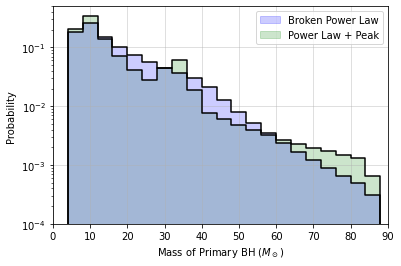

In [ ]:
## Histogram of mass distribution models 

bins = np.arange(0, 100, 4)
plp_hist, bpl_hist = ([0]* len(bins) for i in range(2))

for i in range(len(bins)):
  plp_hist[i] = trapz(y=np.array(plpdist/max(plpdist_int))[(400*i):(400*i+399),], x=masses[(400*i):(400*i+399),])
  bpl_hist[i] = trapz(y=np.array(bpldist/max(bpldist_int))[(400*i):(400*i+399),], x=masses[(400*i):(400*i+399),])

binsplot = bins.repeat(2)
plp_histplot = np.array(plp_hist).repeat(2)
bpl_histplot = np.array(bpl_hist).repeat(2)

binsplot = np.delete(binsplot, 1)
binsplot = np.append(binsplot, 100)

plt.plot(binsplot, plp_histplot, color='black')
plt.plot(binsplot, bpl_histplot, color='black')
plt.fill(binsplot, plp_histplot, 'g', binsplot, bpl_histplot, 'b', alpha=0.2)

plt.yscale('log')
plt.ylim(10**-4, 0.5)
plt.xlim(0, 90)
plt.grid(alpha=0.5)
plt.xlabel('Mass of Primary BH ($M_\odot$)')
plt.ylabel('Probability ')

import matplotlib.patches as mpatches

blue = mpatches.Patch(color='blue', label='Broken Power Law', alpha=0.2)
green = mpatches.Patch(color='green', label='Power Law + Peak', alpha=0.2)

plt.legend(handles=[blue, green])

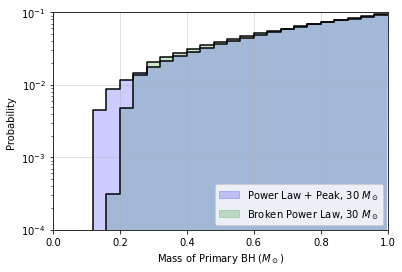

In [ ]:
## Histogram of mass ratio models 

bins = np.arange(0, 1, 0.04)
plpq30_hist, bplq30_hist = ([0]* len(bins) for i in range(2))

for i in range(len(bins)):
  plpq30_hist[i] = trapz(y=np.array(plpq30/max(plpq30_int))[(400*i):(400*i+399),], x=qlist[(400*i):(400*i+399),])
  bplq30_hist[i] = trapz(y=np.array(bplq30/max(bplq30_int))[(400*i):(400*i+399),], x=qlist[(400*i):(400*i+399),])

binsplot = bins.repeat(2)
plpq30_histplot = np.array(plpq30_hist).repeat(2)
bplq30_histplot = np.array(bplq30_hist).repeat(2)

binsplot = np.delete(binsplot, 1)
binsplot = np.append(binsplot, 1)

plt.plot(binsplot, plpq30_histplot, color='black')
plt.plot(binsplot, bplq30_histplot, color='black')
plt.fill(binsplot, plpq30_histplot, 'g', binsplot, bplq30_histplot, 'b', alpha=0.2)

plt.yscale('log')
plt.ylim(10**-4, 10**-1)
plt.xlim(0, 1)
plt.grid(alpha=0.5)
plt.xlabel('Mass of Primary BH ($M_\odot$)')
plt.ylabel('Probability ')

import matplotlib.patches as mpatches

blue = mpatches.Patch(color='blue', label='Power Law + Peak, 30 $M_\odot$', alpha=0.2)
green = mpatches.Patch(color='green', label='Broken Power Law, 30 $M_\odot$', alpha=0.2)

plt.legend(handles=[blue, green])

In [ ]:
## Function for mass bins

def plpbin(peak, alpha, min, max, delta, mu, sigma, bins, binmax, resolution):

  comps = resolution*bins
  bins = np.linspace(binmax/bins, binmax, bins)
  integrand = np.linspace(binmax/comps, binmax, comps)

  binvals = [0] * len(bins)
  integrandvals = [0] * len(integrand)

  for i in range(len(integrand)):
    integrandvals[i] = plp(integrand[i], peak, alpha, min, max, delta, mu, sigma)
  
  integral = trapz(y=np.array(integrandvals), x=integrand)
  integrandvals = np.array(integrandvals) / integral

  for i in range(len(bins)):
    binvals[i] = trapz(y=integrandvals[(resolution*i):(resolution*i+(resolution-1)),], x=integrand[(resolution*i):(resolution*i+(resolution-1)),])
  
  return binvals


def bplbin(alpha1, alpha2, min, max, b, delta, bins, binmax, resolution):

  comps = resolution*bins
  bins = np.linspace(binmax/bins, binmax, bins)
  integrand = np.linspace(binmax/comps, binmax, comps)

  binvals = [0] * len(bins)
  integrandvals = [0] * len(integrand)

  for i in range(len(integrand)):
    integrandvals[i] = bpl(integrand[i], alpha1, alpha2, min, max, b, delta)
  
  integral = trapz(y=np.array(integrandvals), x=integrand)
  integrandvals = integrandvals / integral

  for i in range(len(bins)):
    binvals[i] = trapz(y=integrandvals[(resolution*i):(resolution*i+(resolution-1)),], x=integrand[(resolution*i):(resolution*i+(resolution-1)),])
  
  return binvals

In [ ]:
## Function for mass ratio bins 

def plpqbins(m1, beta, min, delta, bins, resolution):
  comps = resolution*bins
  bins = np.linspace(1/bins, 1, bins)
  integrand = np.linspace(1/comps, 1, comps)
      
  binvals = [0] * len(bins)
  integrandvals = [0] * len(integrand)

  for i in range(len(integrand)):
    integrandvals[i] = plpq(integrand[i], m1, beta, min, delta)

  integral = trapz(y=np.array(integrandvals), x=integrand)
  integrandvals = integrandvals / integral

  for i in range(len(bins)):
    binvals[i] = trapz(y=integrandvals[(resolution*i):(resolution*i+(resolution-1)),], x=integrand[(resolution*i):(resolution*i+(resolution-1)),])

  return binvals
  

def bplqbins(m1, min, beta, bins, resolution):
  comps = resolution*bins
  bins = np.linspace(1/bins, 1, bins)
  integrand = np.linspace(1/comps, 1, comps)
    
  binvals = [0] * len(bins)
  integrandvals = [0] * len(integrand)

  for i in range(len(integrand)):
    integrandvals[i] = bplq(integrand[i], m1, beta, min)

  integral = trapz(y=np.array(integrandvals), x=integrand)
  integrandvals = np.array(integrandvals) / integral

  for i in range(len(bins)):
    binvals[i] = trapz(y=integrandvals[(resolution*i):(resolution*i+(resolution-1)),], x=integrand[(resolution*i):(resolution*i+(resolution-1)),])

  return binvals

In [ ]:
## Combine mass distribution and mass ratio 

massbins = np.linspace(4, 100, 25)
ratiobins = 25
plp_bins, bql_bins = (np.zeros((len(massbins), ratiobins)) for i in range(2))

for i in range(len(massbins)):
  plp_bins[i] = plpqbins(m1=massbins[i], beta=1.26, min=4.59, delta=4.82, bins=ratiobins, resolution=500)
  bql_bins[i] = bplqbins(m1=massbins[i], beta=1.40, min=3.96, bins=ratiobins, resolution=500)


plp_weights, bpl_weights = ([0] * len(massbins) for i in range(2))
plp_weights = plpbin(peak=0.10, alpha=2.63, min=4.59, max=86.22, delta=4.82, mu=33.07, sigma=5.69, bins=25, binmax=100, resolution=10000)
bpl_weights = bplbin(alpha1=1.58, alpha2=5.59, delta=4.83, min=3.96, max=87.14, b=0.43, bins=25, binmax=100, resolution=10000)

for i in range(len(massbins)):
  plp_bins[i] = plp_bins[i] * plp_weights[i]
  bql_bins[i] = bql_bins[i] * bpl_weights[i]

[Text(613.9810909090908, 0.5, '$m_1 \\;\\; (M_\\odot)$'),
 Text(0.5, 22.199999999999996, '$q = m_2/m_1$'),
 Text(0.5, 1.0, 'Broken Power Law Model')]

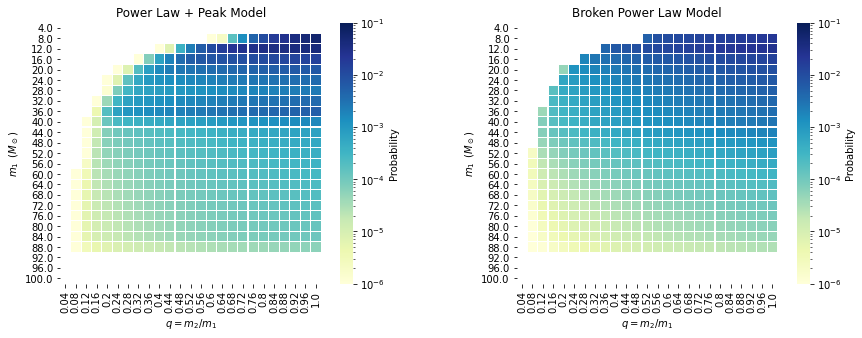

In [ ]:
fig = plt.figure(figsize = (15.0,4.8))

figtitle=['Power Law + Peak', 'Broken Power Law']
massbins = np.around(np.flip(massbins), decimals=0)
ratiobins = np.around(np.linspace(0.04, 1, 25), decimals=2)

heatmap1 = pd.DataFrame(plp_bins, columns=ratiobins, index=massbins)
sns.heatmap(heatmap1, norm=LogNorm(vmin=10**-6, vmax=0.1), ax=fig.add_subplot(1, 2, 1), linewidths=0.1, cmap="YlGnBu", square="True", cbar_kws={'label': 'Probability'}).set(title="Power Law + Peak Model", xlabel="$q = m_2/m_1$", ylabel="$m_1 \;\; (M_\odot)$")

heatmap2 = pd.DataFrame(bql_bins, columns=ratiobins, index=massbins)
sns.heatmap(heatmap2, norm=LogNorm(vmin=10**-6, vmax=0.1), ax=fig.add_subplot(1, 2, 2), linewidths=0.1, cmap="YlGnBu", square="True", cbar_kws={'label': 'Probability'}).set(title="Broken Power Law Model", xlabel="$q = m_2/m_1$", ylabel="$m_1 \;\; (M_\odot)$")



In [ ]:
## Distance estimation function across the mass spectrum (assuming 0 spin)

massbins = np.arange(2, 102, 4)
ratiobins = np.arange(0.06, 1.02, 0.04)

aligodist, aplusdist, cosmicdist = (np.zeros((len(massbins), len(ratiobins))) for i in range(3))
dist = [aligodist, aplusdist, cosmicdist]
psd = ['aLIGODesignSensitivityP1200087', 'aLIGOAPlusDesignSensitivityT1800042', 'CosmicExplorerP1600143']
guess=[2000, 4000, 10000]
flow=[20, 20, 15]

heatmapvals = heatmap2.to_numpy()

for i in range(len(dist)):
  for m in range(len(massbins)):
    for r in range(len(ratiobins)):
      if heatmapvals[m][r] < 10**-6:
        dist[i][m][r] = 0
        print("Mass: {}, Ratio: {}, Distance: NA".format(massbins[m], ratiobins[r]))
      else:
        dist[i][m][r], error = estimate_distance(snr=8, guess=guess[i], alpha=-80, iterations=100, tolerance=0.001,
                                                 mass1=massbins[m], mass2=ratiobins[r]*massbins[m], spin1=[0,0,0], spin2=[0,0,0],
                                                 tmass1=massbins[m], tmass2=ratiobins[r]*massbins[m], tspin1=[0,0,0], tspin2=[0,0,0],
                                                 res=1.0/1024, fres=1.0/16, flow=flow[i], approximant='IMRPhenomPv2', psd=psd[i])
        print("Mass: {}, Ratio: {}, Distance: {}".format(massbins[m], ratiobins[r], dist[i][m][r]))


[Text(958.8620611764707, 0.5, '$m_1 \\;\\; (M_\\odot)$'),
 Text(0.5, 22.199999999999996, '$q = m_2/m_1$'),
 Text(0.5, 1.0, 'Cosmic Explorer Design Sensitivity')]

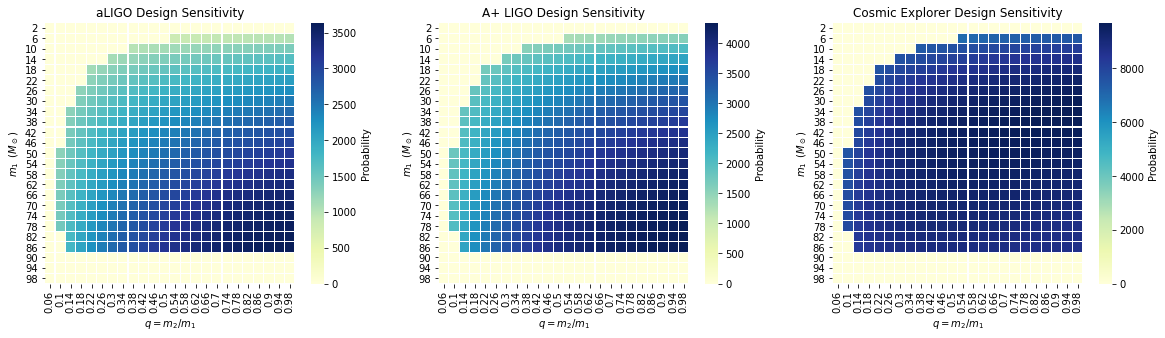

In [ ]:
fig = plt.figure(figsize = (20.0,4.8))

massbins = np.around(np.arange(2, 102, 4), decimals=0)
ratiobins = np.around(np.arange(0.06, 1.02, 0.04), decimals=2)

heatmap = pd.DataFrame(aligodist, columns=ratiobins, index=massbins)
sns.heatmap(heatmap, ax=fig.add_subplot(1, 3, 1), linewidths=0.1, cmap="YlGnBu", square="True", cbar_kws={'label': 'Comoving Distance'}).set(title="aLIGO Design Sensitivity", xlabel="$q = m_2/m_1$", ylabel="$m_1 \;\; (M_\odot)$")

heatmap = pd.DataFrame(aplusdist, columns=ratiobins, index=massbins)
sns.heatmap(heatmap, ax=fig.add_subplot(1, 3, 2), linewidths=0.1, cmap="YlGnBu", square="True", cbar_kws={'label': 'Comoving Distance'}).set(title="A+ LIGO Design Sensitivity", xlabel="$q = m_2/m_1$", ylabel="$m_1 \;\; (M_\odot)$")

heatmap = pd.DataFrame(cosmicdist, columns=ratiobins, index=massbins)
sns.heatmap(heatmap, ax=fig.add_subplot(1, 3, 3), linewidths=0.1, cmap="YlGnBu", square="True", cbar_kws={'label': 'Comoving Distance'}).set(title="Cosmic Explorer Design Sensitivity", xlabel="$q = m_2/m_1$", ylabel="$m_1 \;\; (M_\odot)$")
